## System Identification using Neural Network

In [6]:
import pandas as pd

In [7]:
df = pd.read_csv("data/pump_heatsink_modelling.csv")
COLS = df.columns
df.head()

,Time,Heatsink Temp.,Speed [RPM],Motor Voltage,Motor current
0,2022-02-04 11:26:42,31.0,0.0,0.0,0.0
1,2022-02-04 11:26:52,31.0,0.0,0.0,0.0
2,2022-02-04 11:27:02,31.0,0.0,0.0,0.0
3,2022-02-04 11:27:12,31.0,0.0,0.0,0.0
4,2022-02-04 11:27:22,31.0,0.0,0.0,0.0


In [8]:
import plotly.graph_objects as go
from plotly_resampler import FigureResampler, FigureWidgetResampler
 
 
fig = FigureWidgetResampler(go.Figure())
fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.add_trace(go.Scattergl(name=r'Temperature', showlegend=True), hf_x=df.index, hf_y=df['Heatsink Temp.'])
fig.add_trace(go.Scattergl(name=r'Motor Current', showlegend=True), hf_x=df.index, hf_y=df['Motor current'])
fig.add_trace(go.Scattergl(name=r'Motor Voltage', showlegend=True), hf_x=df.index, hf_y=df['Motor Voltage'])
fig.add_trace(go.Scattergl(name=r'Speed', showlegend=True), hf_x=df.index, hf_y=df['Speed [RPM]'])
fig.update_layout(height=400, template="plotly_dark")
display(fig)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> Temperature <i style="color:#fc9944">~1</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': '0ef3cec8-95fb-4ecf-af30-085c50be71e2',
              'x': array([   0,    1,    2, ..., 1126, 1127, 1129], dtype=uint64),
              'y': array([31., 31., 31., ..., 31., 31., 31.])},
             {'name': ('<b style="color:sandybrown">[R' ... 'i style="color:#fc9944">~1</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': '7974c680-6282-407e-b1b0-f7ada469d1d6',
              'x': array([   0,    1,    2, ..., 1126, 1127, 1129], dtype=uint64),
              'y': array([0., 0., 0., ..., 0., 0., 0.])},
             {'name': ('<b style="color:sandybrown">[R' ... 'i style="color:#fc9944">~1</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'be96cec0-9f88-40d3-a9bd-ec6d8dcd5ca9',
   

## Data Normalization

In [9]:
from sklearn.preprocessing import StandardScaler
time_col = df["Time"]
df = df.drop('Time', axis=1)
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
df_scaled = pd.DataFrame(scaled_data, columns=df.columns, index=df.index)

### Some Basic Visualization Using Resampler

In [10]:

fig = FigureWidgetResampler(go.Figure())
fig.update_layout(margin=dict(l=10, r=10, t=10, b=10))
fig.add_trace(go.Scattergl(name=r'Temperature', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Heatsink Temp.'])
fig.add_trace(go.Scattergl(name=r'Motor Current', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Motor current'])
fig.add_trace(go.Scattergl(name=r'Motor Voltage', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Motor Voltage'])
fig.add_trace(go.Scattergl(name=r'Speed', showlegend=True), hf_x=df_scaled.index, hf_y=df_scaled['Speed [RPM]'])
fig.update_layout(height=400, template="plotly_dark")
display(fig)

FigureWidgetResampler({
    'data': [{'name': '<b style="color:sandybrown">[R]</b> Temperature <i style="color:#fc9944">~1</i>',
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'f76c0abd-12ac-4340-b1f8-649c6514407b',
              'x': array([   0,    1,    2, ..., 1126, 1127, 1129], dtype=uint64),
              'y': array([-1.44317317, -1.44317317, -1.44317317, ..., -1.44317317, -1.44317317,
                          -1.44317317])},
             {'name': ('<b style="color:sandybrown">[R' ... 'i style="color:#fc9944">~1</i>'),
              'showlegend': True,
              'type': 'scattergl',
              'uid': 'f7904730-fac3-4676-a7a7-0a4373bac109',
              'x': array([   0,    1,    2, ..., 1126, 1127, 1129], dtype=uint64),
              'y': array([-1.35322359, -1.35322359, -1.35322359, ..., -1.35322359, -1.35322359,
                          -1.35322359])},
             {'name': ('<b style="color:sandybrown">[R' ... 'i style="colo

### Define Features and Target to Build The NN

In [11]:
train_split_size = 0.7

train_df = df_scaled[:int(train_split_size*len(df_scaled))]
test_df = df_scaled[int(train_split_size*len(df_scaled)):]

FEATURES = ['Speed [RPM]', 'Motor current']
TARGET = 'Heatsink Temp.'

x_train, y_train = train_df[FEATURES].values, train_df[TARGET].values
x_test, y_test= test_df[FEATURES].values, test_df[TARGET].values

### Let's Import SysIdentpy with Pytorch backended

In [12]:
from torch import nn
from sysidentpy.metrics import mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.neural_network import NARXNN

from sysidentpy.basis_function._basis_function import Polynomial, Fourier
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import (
    compute_residues_autocorrelation,
    compute_cross_correlation,
)
from sysidentpy.utils.narmax_tools import regressor_code
import torch

torch.manual_seed(0)

In [13]:
basis_function = Polynomial(degree=1)

narx_net = NARXNN(
    ylag=2,
    xlag=[[2], [2], [2]],
    basis_function=basis_function,
    model_type="NARMAX",
    loss_func="mse_loss",
    optimizer="Adam",
    epochs=100,
    learning_rate = 4e-3,
    verbose=False,
    optim_params={
        "betas": (0.9, 0.999),
        "eps": 1e-05,
    }, 
)

In [14]:
class NARX(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(4, 30)
        self.lin2 = nn.Linear(30, 30)
        self.lin3 = nn.Linear(30, 1)
        self.tanh = nn.Tanh()

    def forward(self, xb):
        z = self.lin(xb)
        z = self.tanh(z)
        z = self.lin2(z)
        z = self.tanh(z)
        z = self.lin3(z)
        return z

In [15]:
narx_net.net = NARX()

In [16]:
narx_net.fit(X=x_train, y=y_train.reshape(-1,1))

In [17]:
yhat = narx_net.predict(X=x_test, y=y_test.reshape(-1,1))

In [18]:
print("MSE: ", mean_squared_error(y_test, yhat))

MSE:  1.635411871529629


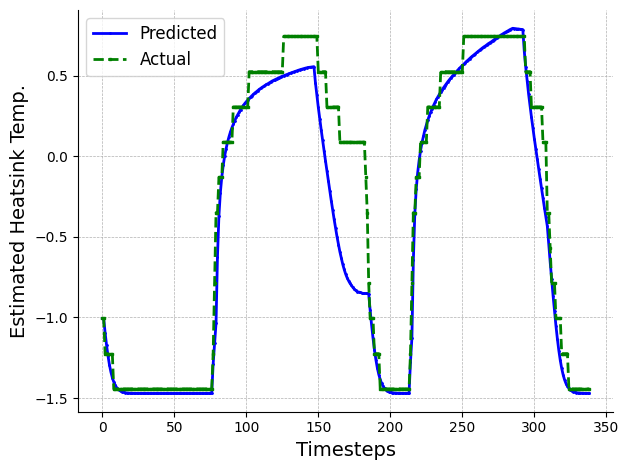

In [19]:
import matplotlib.pyplot as plt 
plt.plot(yhat, color='blue', linestyle='-', linewidth=2, marker='o', markersize=1, label='Predicted')
plt.plot(y_test, color='green', linestyle='--', linewidth=2, marker='s', markersize=1.5, label='Actual')
plt.xlabel('Timesteps', fontsize=14)
plt.ylabel('Estimated Heatsink Temp.', fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Adding a legend
plt.legend(fontsize=12)

# Adjusting the margins and layout
plt.tight_layout()

# Show the plot
plt.show()

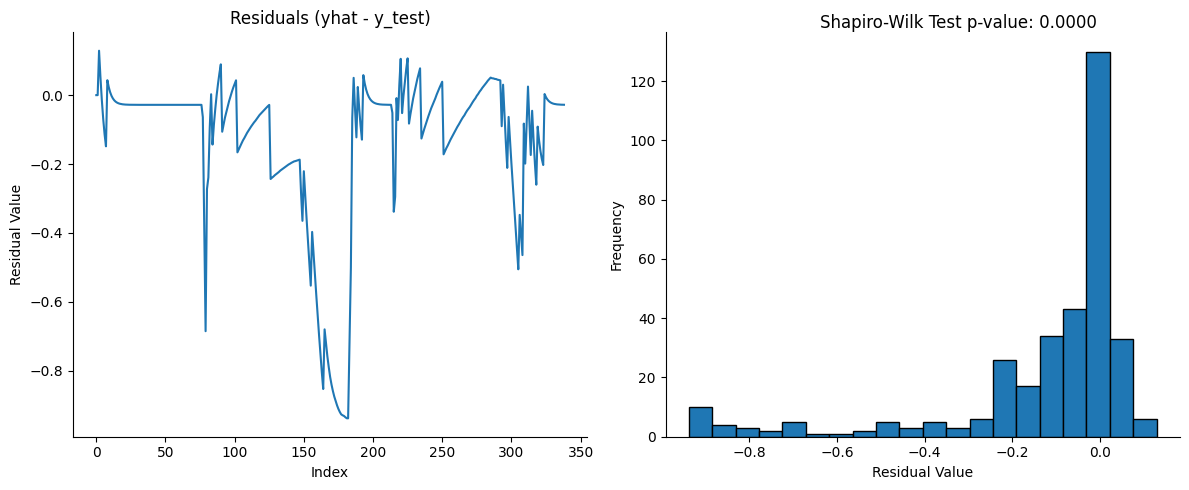

Shapiro-Wilk Test result:
Statistic: 0.6859, p-value: 0.0000


In [20]:
from scipy.stats import shapiro


residuals = yhat.squeeze() - y_test

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: Plot of residuals
axs[0].plot(residuals)
axs[0].set_title('Residuals (yhat - y_test)')
axs[0].set_xlabel('Index')
axs[0].set_ylabel('Residual Value')

# Second subplot: Histogram of residuals
axs[1].hist(residuals, bins=20, edgecolor='black')
axs[1].set_xlabel('Residual Value')
axs[1].set_ylabel('Frequency')

# Perform Shapiro-Wilk Test for normality
stat, p = shapiro(residuals)
axs[1].annotate(f'Shapiro-Wilk Test p-value: {p:.4f}', xy=(0.3, 1.01), xycoords='axes fraction', fontsize=12)

plt.tight_layout()
plt.show()

# Print Shapiro-Wilk Test result
print("Shapiro-Wilk Test result:")
print(f"Statistic: {stat:.4f}, p-value: {p:.4f}")

In [21]:
alpha = 0.05  # significance level
if p > alpha:
    print("The Shapiro-Wilk test is successful: the data follows a normal distribution.")
else:
    print("The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.")

The Shapiro-Wilk test is unsuccessful: the data does not follow a normal distribution.


## Can we do better than this? 
try to: 

- Change the number of lags
- Finetune the Neural Network Architecture (e.g., increase/decrease the layers,
                                                 neurons, activation functions, 
                                                 epochs, learning rate)
- Identify wether possible fix to the systematic error of the model.